In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

from py.split_df import split_df
from py.simulate import simulate
from py.portfolio import Portfolio

In [2]:
# Variables

assets = ['ETH', 'USD']

# We'll use 180 day windows (6 months) with 120 day overlap (4 months)
# Since our dataframe is in hours, multiply by 24
window_len = 24 * 180
overlap = 24 * 120

allocation = {
    'bull': [0.85, 0.15],
    'neutral': [0.50, 0.50],
    'bear': [0.15, 0.85]
}

wiggle_room = 0.10

drawdown_eth = []
drawdown_rebalanced = []
end_pct_eth = []
end_pct_rebalanced = []


df_signals = pd.read_csv('backtests/signals.csv').to_dict(orient='records')

In [3]:
# Helper functions

def calc_drawdown(array):

    max_drawdown = 0

    for i in range(1, len(array)):
        prev_max = max(array[:i])
        future_min = min(array[i:])

        drawdown = (prev_max - future_min) / prev_max

        if drawdown > max_drawdown:
            max_drawdown = drawdown

    return max_drawdown


def calc_end_pct(array):
    return (array[-1] - array[0]) / array[0]

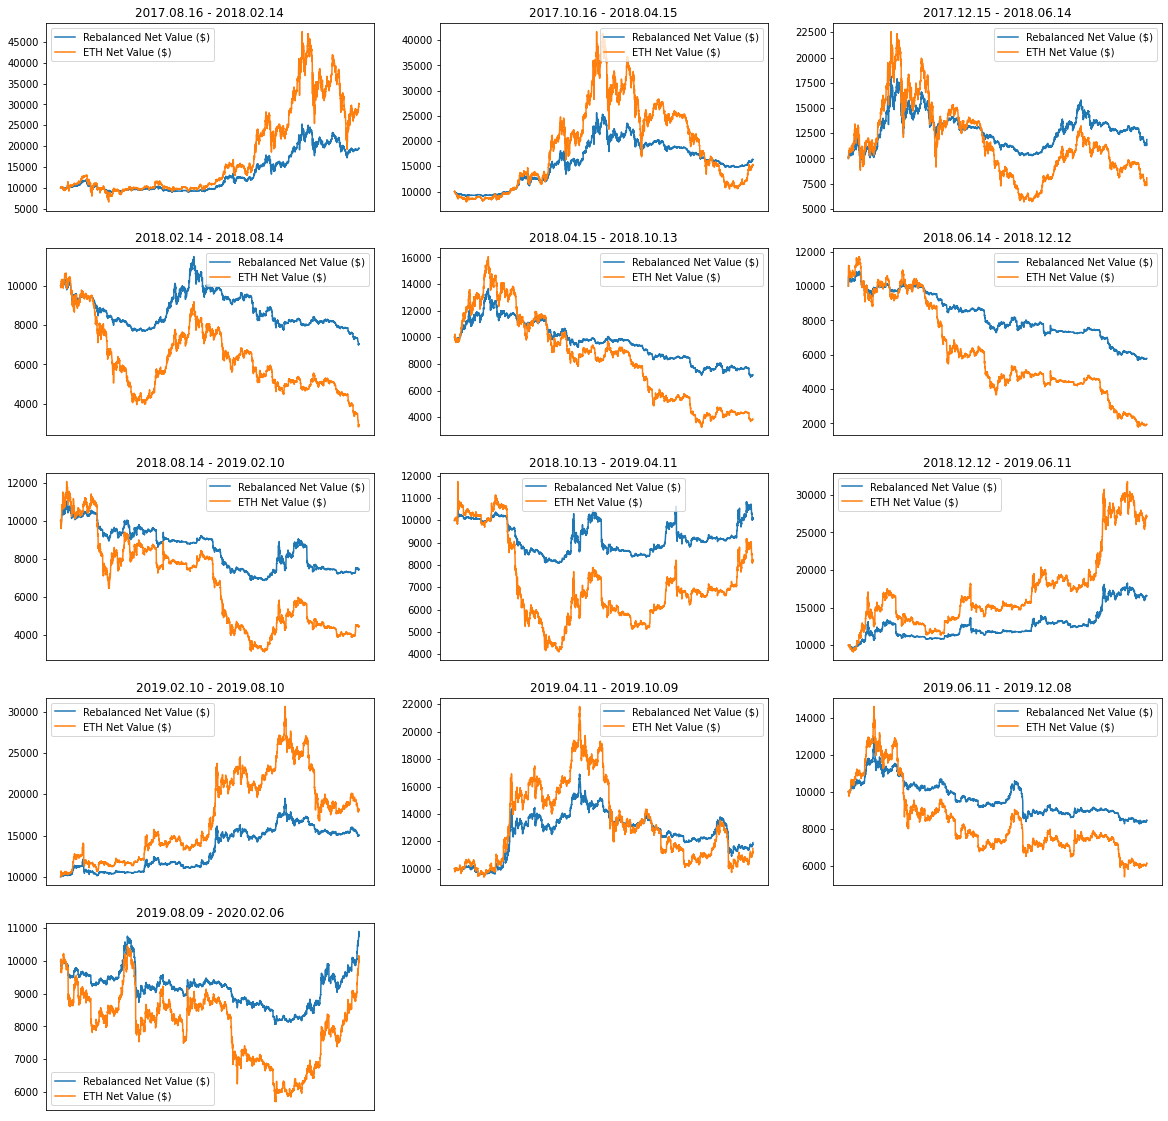

In [4]:
# Display charts

fig = plt.figure(figsize=(20, 20))


for i, df in enumerate(split_df(df_signals, overlap, window_len)):

    rebalanced, eth, _ = simulate(assets, allocation, wiggle_room, df)

    # Append calculations
    drawdown_eth.append(calc_drawdown(eth))
    drawdown_rebalanced.append(calc_drawdown(rebalanced))
    end_pct_eth.append(calc_end_pct(eth))
    end_pct_rebalanced.append(calc_end_pct(rebalanced))

    df_plot = pd.DataFrame({'Rebalanced Net Value ($)': rebalanced, 'ETH Net Value ($)': eth})

    ax = fig.add_subplot(5, 3, i+1)
    ax.plot(df_plot)
    ax.legend(df_plot.columns, loc='best')

    start, end = df[0]['date'][:df[0]['date'].find(' ')], df[-1]['date'][:df[-1]['date'].find(' ')]
    ax.set_title(f"{start} - {end}")
    ax.set_xticks([])

plt.show()

In [6]:
# Summary

df_drawdown = pd.DataFrame({'ETH': drawdown_eth, 'Rebalanced': drawdown_rebalanced})

print(f'Absolute Max Drawdown over 6 months: \n{df_drawdown.max()}\n')
print(f'Average Max Drawdown over 6 months: \n{df_drawdown.mean()}\n')


df_end_pct = pd.DataFrame({'ETH': end_pct_eth, 'Rebalanced': end_pct_rebalanced})

print(f'Average End Profit over 6 months: \n{df_end_pct.mean()}')

Absolute Max Drawdown over 6 months: 
ETH           0.846802
Rebalanced    0.487941
dtype: float64

Average Max Drawdown over 6 months: 
ETH           0.638917
Rebalanced    0.349068
dtype: float64

Average End Profit over 6 months: 
ETH           0.136144
Rebalanced    0.139419
dtype: float64
